In [ ]:
!pip install tensorflow-recommenders

In [ ]:
import json
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
from typing import Dict, Text
import os
import pprint
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

with open("data_produk.JSON") as f:
    data = json.load(f)

masterdf = pd.json_normalize(data)
masterdf





,Id_produk,Id_user,Nama_produk,Nama_umkm,Kategori_produk,Harga,Bahan_baku
0,P001,U101,Minyak Zaitun Extra Virgin,Olive Harvest,Makanan,75000,Zaitun
1,P002,U202,Kemeja Batik Premium,Batik Elegance,Fashion,300000,"Katun, Lilin Malam"
2,P003,U303,Sabun Organik Lavender,Nature Bliss,Kesehatan,45000,"Minyak Kelapa, Lavender, Garam Himalaya"
3,P004,U404,Meja Kerja Kayu Jati,Jati Furniture,Furniture,1200000,Kayu Jati
4,P005,U505,Sandal Rajut Tenun,Rajut Craft,Fashion,85000,"Benang Rajut, Kulit Sintetis"
...,...,...,...,...,...,...,...
107,P109,U909,Es Teh Lemon,LemonChill,Minuman,25000,"Teh Hitam, Lemon, Es"
108,P110,U010,Penghapus Pensil,EraserEase,Perlengkapan Kantor,5000,"Karet, Plastik"
109,P111,U111,Healthy Skin's Jamu,Homa Herbs,Minuman,10000,"Apple, Turmeric, Black Papper, Ginger, Madu"
110,P112,U222,Body Detox's Jamu,Homa Herbs,Minuman,10000,"Ginger, Pineapple, Mint, Lemon"


In [ ]:
masterdf[['Id_produk', 'Id_user', 'Nama_produk',
       'Nama_umkm', 'Kategori_produk','Harga', 'Bahan_baku' ]]

,Id_produk,Id_user,Nama_produk,Nama_umkm,Kategori_produk,Harga,Bahan_baku
0,P001,U101,Minyak Zaitun Extra Virgin,Olive Harvest,Makanan,75000,Zaitun
1,P002,U202,Kemeja Batik Premium,Batik Elegance,Fashion,300000,"Katun, Lilin Malam"
2,P003,U303,Sabun Organik Lavender,Nature Bliss,Kesehatan,45000,"Minyak Kelapa, Lavender, Garam Himalaya"
3,P004,U404,Meja Kerja Kayu Jati,Jati Furniture,Furniture,1200000,Kayu Jati
4,P005,U505,Sandal Rajut Tenun,Rajut Craft,Fashion,85000,"Benang Rajut, Kulit Sintetis"
...,...,...,...,...,...,...,...
107,P109,U909,Es Teh Lemon,LemonChill,Minuman,25000,"Teh Hitam, Lemon, Es"
108,P110,U010,Penghapus Pensil,EraserEase,Perlengkapan Kantor,5000,"Karet, Plastik"
109,P111,U111,Healthy Skin's Jamu,Homa Herbs,Minuman,10000,"Apple, Turmeric, Black Papper, Ginger, Madu"
110,P112,U222,Body Detox's Jamu,Homa Herbs,Minuman,10000,"Ginger, Pineapple, Mint, Lemon"


In [ ]:
masterdf[['Id_user',
          'Id_produk',
         ]] = masterdf[['Id_user','Id_produk']].astype(str)

masterdf['Harga'] = masterdf['Harga'].astype(float)

In [ ]:
interactions_dict = masterdf.groupby(['Id_user', 'Id_produk'])[ 'Harga'].sum().reset_index()

interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

items_dict = masterdf[['Id_produk']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

interactions = interactions.map(lambda x: {
    'Id_user' : x['Id_user'],
    'Id_produk' : x['Id_produk'],
    'Harga' : float(x['Harga']),

})

items = items.map(lambda x: x['Id_produk'])

In [ ]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(100))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(10).map(lambda x: x["Id_user"]))))

In [ ]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(100))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(100).map(lambda x: x["Id_user"]))))

tf.random.set_seed(42)
shuffled = interactions.shuffle(100, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80)
test = shuffled.skip(80).take(20)

In [ ]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        self.item_model: tf.keras.Model = item_model

        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),

                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model


        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model)

                                            )
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )

        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["Id_user"])
        positive_movie_embeddings = self.item_model(features["Id_produk"])

        return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:

embedding_dimension = 32
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(1_000).batch(1024).cache()
cached_test = test.batch(512).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model

Epoch 1/10
1/1 [==============================] - 5s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0125 - factorized_top_k/top_5_categorical_accuracy: 0.0625 - factorized_top_k/top_10_categorical_accuracy: 0.0750 - factorized_top_k/top_50_categorical_accuracy: 0.4875 - factorized_top_k/top_100_categorical_accuracy: 0.8250 - loss: 350.5757 - regularization_loss: 0.0000e+00 - total_loss: 350.5757
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.4125 - factorized_top_k/top_10_categorical_accuracy: 0.8000 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 349.2824 - regularization_loss: 0.0000e+00 - total_loss: 349.2824
Epoch 3/10
1/1 [==============================] - 0s 48ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.5125 -

In [ ]:
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 363ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.6500 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 59.8446 - regularization_loss: 0.0000e+00 - total_loss: 59.8446


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.6499999761581421,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 59.84461975097656,
 'regularization_loss': 0,
 'total_loss': 59.84461975097656}

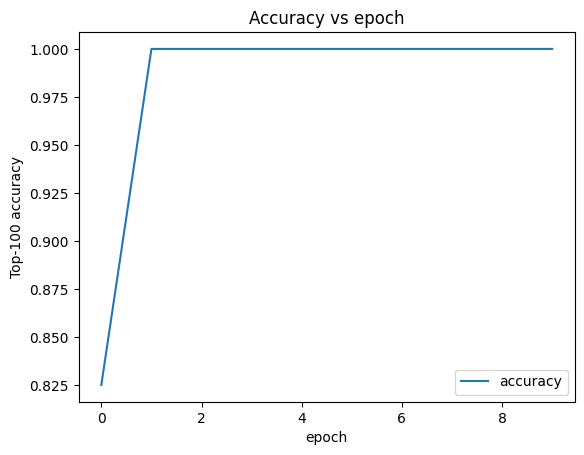

In [ ]:
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()